## AGL Wind Farm Power Prediction Notebook  

### This version is a modified version of https://github.com/osisoft/sample-ocs-data_views_jupyter-python/blob/main/Wind_Turbine_OCS_Data_OCS_Python_Library.ipynb for the [Academic Hub Wind Farms dataset](https://academic.osisoft.com/datasets)

**Install the Academic Hub library and supporting modules if run outside of Binder**

In [1]:
import os

if not os.environ.get("BINDER_LAUNCH_HOST"):
    !pip install ocs_academic_hub plotly matplotlib sklearn

     |████████████████████████████████| 68 kB 8.3 MB/s 
     |████████████████████████████████| 41 kB 994 kB/s 
     |████████████████████████████████| 121 kB 29.3 MB/s 
     |████████████████████████████████| 243 kB 7.7 MB/s 
     |████████████████████████████████| 1.6 MB 32.6 MB/s 
     |████████████████████████████████| 252 kB 28.1 MB/s 
     |████████████████████████████████| 179 kB 17.2 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=5aad60eb65bb4b5dca59a5851329422cd8bce62bf3a5fb164ac4cb1e98b031dd
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21493 sha256=3b0e23d3e940abf1781aa5139044b6875ddd83f4d2efd9191c2276af8828efa9
  Stored in directory: /root/.cache/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Successfully built sklearn promise
You should consider upgrading via the '/root/ve

### Import required modules and hub_login

In [2]:
import requests
import json
import pandas as pd
from datetime import date, timedelta

import matplotlib.pyplot as plt
import numpy as np

from ocs_academic_hub.datahub import hub_login

### Login to Academic Hub by running the next cell

**Execute the cell below and follow the indicated steps to log in (an AVEVA banner would show up)** 

In [3]:
widget, hub = hub_login()
widget

<IPython.core.display.Javascript object>

### Standard Hub Datasets

Note: Wind Farm dataset is not part of Hub standard datasets. For more info on those: https://academic.osisoft.com/datasets

In [4]:
hub.datasets()

['Brewery',
 'Campus_Energy',
 'Classroom_Data',
 'MIT',
 'Pilot_Plant',
 'USC_Well_Data',
 'Wind_Farms']

### Request dataset information for the lab

In [5]:
hub.refresh_datasets(experimental=True)

### Check that WindFarm dataset is now available

In [6]:
hub.datasets()

['Brewery',
 'Campus_Energy',
 'Classroom_Data',
 'MIT',
 'Pilot_Plant',
 'USC_Well_Data',
 'Wind_Farms']

### Make it the current dataset

In [7]:
hub.set_dataset("Wind_Farms")
hub.current_dataset()

'Wind_Farms'

### OCS namespace where data lives

In [8]:
namespace_id = hub.namespace_of("Wind_Farms")
namespace_id

'academic_hub_01'

### List the assets in dataset

There are 10 wind turbines times 5 cluster (total of 50)

In [9]:
hub.assets()

,Asset_Id,Description
0,cluster1.turb1,Turbine
1,cluster1.turb10,Turbine
2,cluster1.turb2,Turbine
3,cluster1.turb3,Turbine
4,cluster1.turb4,Turbine
5,cluster1.turb5,Turbine
6,cluster1.turb6,Turbine
7,cluster1.turb7,Turbine
8,cluster1.turb8,Turbine
9,cluster1.turb9,Turbine


### Assets metadata

Store data about cluster no.4 into dataframe `df_meta` for map plot in next section

In [10]:
df_metadata = hub.all_assets_metadata()
df_meta = df_metadata[df_metadata.Asset_Id.apply(lambda s: s[:8] == "cluster4")]
df_meta

,Cluster,ID,Latitude,Longitude,Manufacturer,Model,Asset_Id
1,4,1,-33.294081,138.731074,,,cluster4.turb1
6,4,10,-33.302959,138.718843,,,cluster4.turb10
11,4,2,-33.297077,138.728607,,,cluster4.turb2
19,4,3,-33.296198,138.706698,,,cluster4.turb3
20,4,4,-33.295929,138.712857,,,cluster4.turb4
25,4,5,-33.296198,138.719079,,,cluster4.turb5
31,4,6,-33.298906,138.723414,,,cluster4.turb6
39,4,7,-33.300430,138.727212,,,cluster4.turb7
40,4,8,-33.301506,138.707042,,,cluster4.turb8
47,4,9,-33.300915,138.712792,,,cluster4.turb9


### Map of Wind Turbines

**Below is a screenshot of map plot using the metadata of cluster no.4**
![](https://academichub.blob.core.windows.net/images/agl_cluster4_map.png)

#### Code for map generation using Plotly

With higher zoom to see turbine location and its ID better, including a different style to show terrain.

In [11]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_meta,
    lat="Latitude",
    lon="Longitude",
    text="Asset_Id",
    zoom=12.0,
    title="Locations of Cluster 4 wind turbines (green dots)",
)
fig.update_traces(marker=dict(size=12, color="red"))
# fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

<details>
    <summary><b>NOTE: the graph above doesn't show correctly on Github, click here to see a screenshot</b></summary>
<a><img alt="Qries" src="https://academichub.blob.core.windows.net/images/agl_cluster4_map_statmen.png"></a>
</details>

### Get the list of all single-asset data views

In [12]:
hub.asset_dataviews()

['wind.farms_cluster1.turb1',
 'wind.farms_cluster1.turb10',
 'wind.farms_cluster1.turb2',
 'wind.farms_cluster1.turb3',
 'wind.farms_cluster1.turb4',
 'wind.farms_cluster1.turb5',
 'wind.farms_cluster1.turb6',
 'wind.farms_cluster1.turb7',
 'wind.farms_cluster1.turb8',
 'wind.farms_cluster1.turb9',
 'wind.farms_cluster2.turb1',
 'wind.farms_cluster2.turb10',
 'wind.farms_cluster2.turb2',
 'wind.farms_cluster2.turb3',
 'wind.farms_cluster2.turb4',
 'wind.farms_cluster2.turb5',
 'wind.farms_cluster2.turb6',
 'wind.farms_cluster2.turb7',
 'wind.farms_cluster2.turb8',
 'wind.farms_cluster2.turb9',
 'wind.farms_cluster3.turb1',
 'wind.farms_cluster3.turb10',
 'wind.farms_cluster3.turb2',
 'wind.farms_cluster3.turb3',
 'wind.farms_cluster3.turb4',
 'wind.farms_cluster3.turb5',
 'wind.farms_cluster3.turb6',
 'wind.farms_cluster3.turb7',
 'wind.farms_cluster3.turb8',
 'wind.farms_cluster3.turb9',
 'wind.farms_cluster4.turb1',
 'wind.farms_cluster4.turb10',
 'wind.farms_cluster4.turb2',
 'wind

### Get the list of all multiple-asset data views 

**NOTE: Only one such data view is defined now, for cluster no.4**

In [13]:
dataview_id = hub.asset_dataviews("", multiple_asset=True)[0]
dataview_id

'wind.farms_cluster1'

### Verify the structure of the data view

For wind turbine `cluster4.turb1` (data view `wind.farms_cluster4` is similar but with all turbines of cluster no.4)

In [14]:
hub.dataview_definition(namespace_id, "wind.farms_cluster4.turb1")

,Asset_Id,Column_Name,Stream_Type,Stream_UOM,OCS_Stream_Name
4,cluster4.turb1,Ambient Temperature,Float,°C,cluster4.turb1.temp_ambient
5,cluster4.turb1,Drivetrain Gearbox Temp IMSDE,Float,°C,cluster4.turb1.temp_drivetrain_gearbox_IMSDE
6,cluster4.turb1,Drivetrain Gearbox Temp IMSNDE,Float,°C,cluster4.turb1.temp_drivetrain_gearbox_IMSNDE
7,cluster4.turb1,Drivetrain Mainbearing Temp,Float,°C,cluster4.turb1.temp_drivetrain_mainbearing
9,cluster4.turb1,Drivetrain vibration,Float,m/s²,cluster4.turb1.vib_drive_train
8,cluster4.turb1,Nacelle Temp,Float,°C,cluster4.turb1.temp_nacelle
1,cluster4.turb1,Pitch Angle,Float,degrees,cluster4.turb1.pitch_angle
2,cluster4.turb1,Power To Grid,Float,kW,cluster4.turb1.power_to_grid
10,cluster4.turb1,Relative Wind Direction,Float,degrees,cluster4.turb1.wind_direction_relative
3,cluster4.turb1,Rotor Speed,Float,RPM,cluster4.turb1.rotor_rpm


### Request data view result

For 2 months starting on 2019-01-01, interpolated every hour. Method `dataview_interpolated_pd` takes care of gathering multiple pages of data and returning a single Pandas dataframe.  

In [29]:
dateFrom = "2019-01-01"
dateTo = "2019-03-01"
timeinterval = "01:00:00" # format is HH:MM:SS 

df = hub.dataview_interpolated_pd(
    namespace_id, dataview_id, dateFrom, dateTo, timeinterval, count=1000
)
df

++++++++++++++
  ==> Finished 'dataview_interpolated_pd' in       126.9845 secs [ 112 rows/sec ]


,Timestamp,Asset_Id,Pitch Angle,Power To Grid,Rotor Speed,Ambient Temperature,Drivetrain Gearbox Temp IMSDE,Drivetrain Gearbox Temp IMSNDE,Drivetrain Mainbearing Temp,Nacelle Temp,Drivetrain vibration,Relative Wind Direction,Wind Speed,Yaw Angle,State
0,2019-01-01 00:00:00,cluster1.turb1,19.646260,-1.548519,4.378319,28.000000,48.255636,49.646158,34.0,34.000000,-0.007768,18.720086,3.967715,82.762159,OK
1,2019-01-01 01:00:00,cluster1.turb1,19.733920,-1.410588,2.118582,32.000000,48.000000,48.909174,34.0,35.000000,-0.010713,34.105076,2.384752,146.544547,OK
2,2019-01-01 02:00:00,cluster1.turb1,19.904766,-0.349324,1.727816,34.620236,47.000000,47.000000,34.0,35.000000,0.081884,12.056201,2.098440,143.129119,OK
3,2019-01-01 03:00:00,cluster1.turb1,19.707443,-3.057826,3.280488,33.130995,47.168527,49.491698,34.0,35.000000,0.230124,4.647357,3.760916,181.544962,OK
4,2019-01-01 04:00:00,cluster1.turb1,8.265666,-9.018680,13.473622,33.000000,50.023570,53.895664,35.0,36.855292,0.378363,-5.866972,8.153481,164.834708,OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,55.221651,58.498088,42.0,35.446638,0.005341,11.729414,5.895554,357.460886,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,60.420620,64.000000,42.0,36.000000,0.005341,0.200718,5.793121,343.472022,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,54.000000,58.000000,43.0,35.588320,0.005341,-10.695703,12.826008,346.996009,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,58.423171,62.244062,43.0,38.000000,0.005341,-0.897508,7.560330,349.038549,OK


In [30]:
# Structure of dataframe
data_file = "cluster1_1h.csv"
df.to_csv(data_file)
# df = pd.read_csv(data_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14170 entries, 0 to 14169
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Timestamp                       14170 non-null  datetime64[ns]
 1   Asset_Id                        14170 non-null  object        
 2   Pitch Angle                     14170 non-null  float64       
 3   Power To Grid                   14170 non-null  float64       
 4   Rotor Speed                     14170 non-null  float64       
 5   Ambient Temperature             14170 non-null  float64       
 6   Drivetrain Gearbox Temp IMSDE   14170 non-null  float64       
 7   Drivetrain Gearbox Temp IMSNDE  14170 non-null  float64       
 8   Drivetrain Mainbearing Temp     14170 non-null  float64       
 9   Nacelle Temp                    14170 non-null  float64       
 10  Drivetrain vibration            14170 non-null  float64       
 11  Re

In [31]:
# Renaming DataFrame column names to abbreviations, in order to display these column names clearly in
# a correlation plot

df = df.rename(
    columns={
        "Rotor Speed": "RS",
        "State": "TS",
        "Power To Grid": "AP",  # Active Power
        "Pitch Angle": "NP",
        "Ambient Temperature": "AT",
        "Wind Speed": "WS",
    }
)
# Dropping unneeded columns
#
columns_to_drop = [
    c
    for c in df.columns
    if any(i in c for i in ["Drive", "Nacelle", "Yaw", "Relative"])
]
columns_to_drop
df = df.drop(columns_to_drop, axis=1)

# Turbine should be in a good state for data to be valid
df = df[df["TS"] == "OK"]
df

,Timestamp,Asset_Id,NP,AP,RS,AT,WS,TS
0,2019-01-01 00:00:00,cluster1.turb1,19.646260,-1.548519,4.378319,28.000000,3.967715,OK
1,2019-01-01 01:00:00,cluster1.turb1,19.733920,-1.410588,2.118582,32.000000,2.384752,OK
2,2019-01-01 02:00:00,cluster1.turb1,19.904766,-0.349324,1.727816,34.620236,2.098440,OK
3,2019-01-01 03:00:00,cluster1.turb1,19.707443,-3.057826,3.280488,33.130995,3.760916,OK
4,2019-01-01 04:00:00,cluster1.turb1,8.265666,-9.018680,13.473622,33.000000,8.153481,OK
...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,5.895554,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,5.793121,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,12.826008,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,7.560330,OK


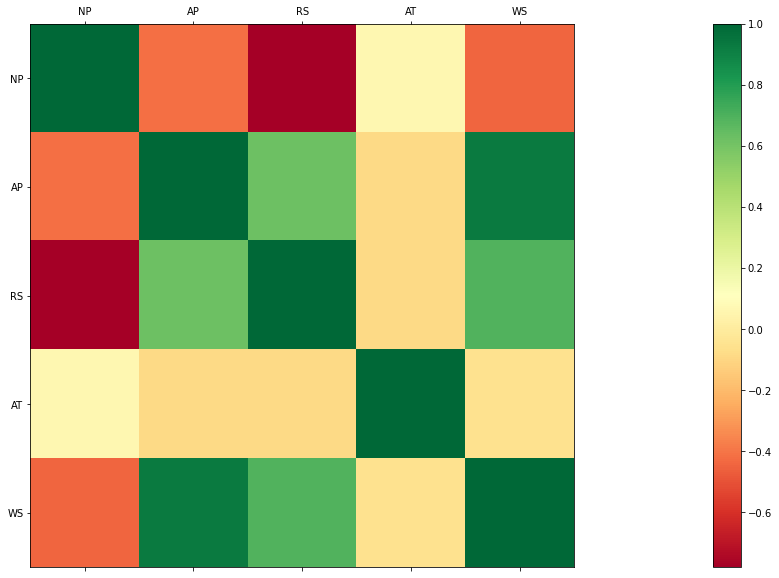

In [32]:
# Check the correlation between Active Power and the rest of the variables

# retrieve the correlation table
df_corr = df.corr()

# increase the size of the figure
fig = plt.figure(figsize=(50, 10))
ax = fig.add_subplot(111)

# set the color pallete (Red, yellow, green)
cax = ax.matshow(df_corr, cmap=plt.cm.RdYlGn)
fig.colorbar(cax)

# configure the labels
labels = [c for c in df_corr.columns]

# make sure to show all the labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

# Setting labels for the x and y axes of the correlation plot
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.show(block=False)

In [33]:
# Renaming DataFrame column names from abbreviations back to their original full names

df= df.rename(
    columns={
        "RS": "Rotor Speed",
        "TS": "Turbine State",
        "AP": "Active Power",
        "NP": "Nacelle Position",
        "AT": "Air Temperature",
        "WS": "Wind Speed",
    }
)
df

,Timestamp,Asset_Id,Nacelle Position,Active Power,Rotor Speed,Air Temperature,Wind Speed,Turbine State
0,2019-01-01 00:00:00,cluster1.turb1,19.646260,-1.548519,4.378319,28.000000,3.967715,OK
1,2019-01-01 01:00:00,cluster1.turb1,19.733920,-1.410588,2.118582,32.000000,2.384752,OK
2,2019-01-01 02:00:00,cluster1.turb1,19.904766,-0.349324,1.727816,34.620236,2.098440,OK
3,2019-01-01 03:00:00,cluster1.turb1,19.707443,-3.057826,3.280488,33.130995,3.760916,OK
4,2019-01-01 04:00:00,cluster1.turb1,8.265666,-9.018680,13.473622,33.000000,8.153481,OK
...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,5.895554,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,5.793121,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,12.826008,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,7.560330,OK


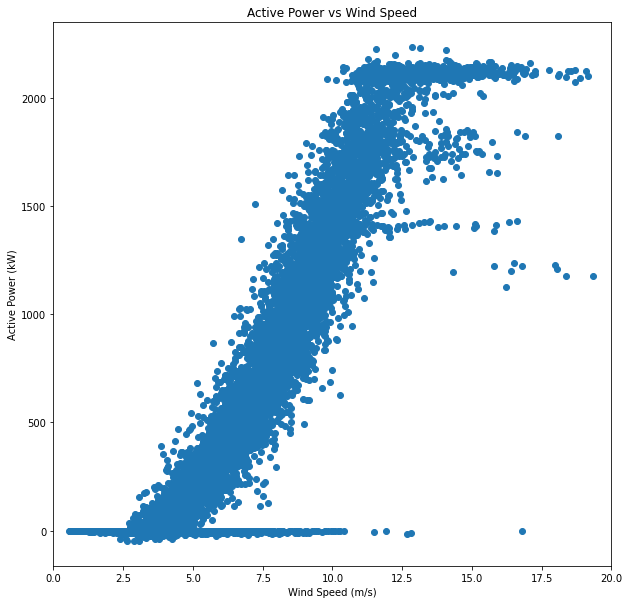

In [34]:
# Plotting Active Power versus Wind Speed

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(df["Wind Speed"], df["Active Power"])
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Active Power (kW)")
ax.set_title("Active Power vs Wind Speed")
ax.set_xlim([0,20])

plt.show(block=False)

In [35]:
# Filter out rows with missing data (if any)
#
df_Filter = df.dropna()
df_Filter

,Timestamp,Asset_Id,Nacelle Position,Active Power,Rotor Speed,Air Temperature,Wind Speed,Turbine State
0,2019-01-01 00:00:00,cluster1.turb1,19.646260,-1.548519,4.378319,28.000000,3.967715,OK
1,2019-01-01 01:00:00,cluster1.turb1,19.733920,-1.410588,2.118582,32.000000,2.384752,OK
2,2019-01-01 02:00:00,cluster1.turb1,19.904766,-0.349324,1.727816,34.620236,2.098440,OK
3,2019-01-01 03:00:00,cluster1.turb1,19.707443,-3.057826,3.280488,33.130995,3.760916,OK
4,2019-01-01 04:00:00,cluster1.turb1,8.265666,-9.018680,13.473622,33.000000,8.153481,OK
...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,5.895554,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,5.793121,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,12.826008,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,7.560330,OK


In [36]:
# Filter out negative & excessive Active Power Values
filterNegativeActivePower = df_Filter["Active Power"] >= 0
df_Filter = df_Filter[filterNegativeActivePower]
df_Filter

,Timestamp,Asset_Id,Nacelle Position,Active Power,Rotor Speed,Air Temperature,Wind Speed,Turbine State
7,2019-01-01 07:00:00,cluster1.turb1,0.255573,825.312822,15.007162,33.000000,8.777149,OK
8,2019-01-01 08:00:00,cluster1.turb1,0.839111,387.941005,15.277446,32.748379,6.587068,OK
9,2019-01-01 09:00:00,cluster1.turb1,0.749939,1943.823959,15.376954,30.000000,11.884919,OK
10,2019-01-01 10:00:00,cluster1.turb1,6.905896,2089.754023,15.476463,26.000000,13.074598,OK
11,2019-01-01 11:00:00,cluster1.turb1,0.594658,1701.156339,15.575972,24.000000,10.971947,OK
...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,5.895554,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,5.793121,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,12.826008,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,7.560330,OK


In [37]:
# Remove the rows where we have a high wind speed and low active power in order to keep only the normal operating conditions
filterOutLowPowerHighWindSpeedData = ~(
    (df_Filter["Wind Speed"] > 10) & (df_Filter["Active Power"] < 600)
)
df_Filter = df_Filter[filterOutLowPowerHighWindSpeedData]
df_Filter

,Timestamp,Asset_Id,Nacelle Position,Active Power,Rotor Speed,Air Temperature,Wind Speed,Turbine State
7,2019-01-01 07:00:00,cluster1.turb1,0.255573,825.312822,15.007162,33.000000,8.777149,OK
8,2019-01-01 08:00:00,cluster1.turb1,0.839111,387.941005,15.277446,32.748379,6.587068,OK
9,2019-01-01 09:00:00,cluster1.turb1,0.749939,1943.823959,15.376954,30.000000,11.884919,OK
10,2019-01-01 10:00:00,cluster1.turb1,6.905896,2089.754023,15.476463,26.000000,13.074598,OK
11,2019-01-01 11:00:00,cluster1.turb1,0.594658,1701.156339,15.575972,24.000000,10.971947,OK
...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,5.895554,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,5.793121,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,12.826008,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,7.560330,OK


In [38]:
# Filter out high Wind Speeds (> 13 m/s) that do not change the Active Power results
filterOutHighWind = df_Filter["Wind Speed"] < 13
df_Filter = df_Filter[filterOutHighWind]
df_Filter

,Timestamp,Asset_Id,Nacelle Position,Active Power,Rotor Speed,Air Temperature,Wind Speed,Turbine State
7,2019-01-01 07:00:00,cluster1.turb1,0.255573,825.312822,15.007162,33.000000,8.777149,OK
8,2019-01-01 08:00:00,cluster1.turb1,0.839111,387.941005,15.277446,32.748379,6.587068,OK
9,2019-01-01 09:00:00,cluster1.turb1,0.749939,1943.823959,15.376954,30.000000,11.884919,OK
11,2019-01-01 11:00:00,cluster1.turb1,0.594658,1701.156339,15.575972,24.000000,10.971947,OK
12,2019-01-01 12:00:00,cluster1.turb1,0.073214,553.491649,15.220907,21.200666,5.952715,OK
...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,5.895554,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,5.793121,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,12.826008,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,7.560330,OK


In [39]:
# Also remove low active power rows, cutoff at 100kW
#
df_Filter = df_Filter[df_Filter["Active Power"] > 100]
df_Filter

,Timestamp,Asset_Id,Nacelle Position,Active Power,Rotor Speed,Air Temperature,Wind Speed,Turbine State
7,2019-01-01 07:00:00,cluster1.turb1,0.255573,825.312822,15.007162,33.000000,8.777149,OK
8,2019-01-01 08:00:00,cluster1.turb1,0.839111,387.941005,15.277446,32.748379,6.587068,OK
9,2019-01-01 09:00:00,cluster1.turb1,0.749939,1943.823959,15.376954,30.000000,11.884919,OK
11,2019-01-01 11:00:00,cluster1.turb1,0.594658,1701.156339,15.575972,24.000000,10.971947,OK
12,2019-01-01 12:00:00,cluster1.turb1,0.073214,553.491649,15.220907,21.200666,5.952715,OK
...,...,...,...,...,...,...,...,...
14165,2019-02-28 20:00:00,cluster1.turb9,0.704913,450.181656,15.382127,28.000000,5.895554,OK
14166,2019-02-28 21:00:00,cluster1.turb9,0.221421,706.859494,15.445756,28.000000,5.793121,OK
14167,2019-02-28 22:00:00,cluster1.turb9,0.707875,2113.420673,15.509385,29.000000,12.826008,OK
14168,2019-02-28 23:00:00,cluster1.turb9,0.370103,756.285030,15.573014,31.000000,7.560330,OK


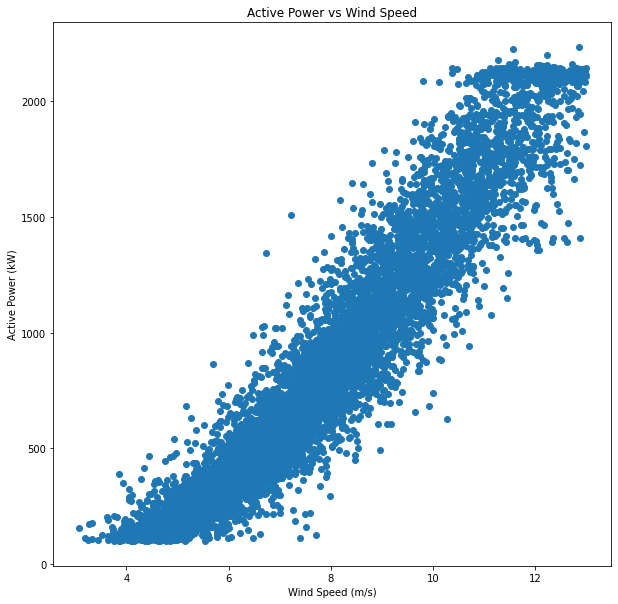

In [40]:
# Plotting Active Power versus Wind Speed - filtered data frame representing Normal Operating Conditions

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(df_Filter["Wind Speed"], df_Filter["Active Power"])
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Active Power (kW)")
ax.set_title("Active Power vs Wind Speed")

plt.show(block=False)

In [41]:
# Prepare the training & testing/scoring data sets, and split them randomly
from sklearn.model_selection import train_test_split

# define the target variable to be predicted
y = df_Filter["Active Power"].values
# split the dataset randomly into test and train sets
X_train, X_test, y_train, y_test = train_test_split(
    df_Filter[["Air Temperature", "Wind Speed"]].values,
    y,
    test_size=0.25,
    random_state=42,
)
print("-- training and testing set prepared --")

-- training and testing set prepared --


In [42]:
# Use the Decision Tree Regression Machine Learning model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
print("-- regression and prediction completed --")

-- regression and prediction completed --


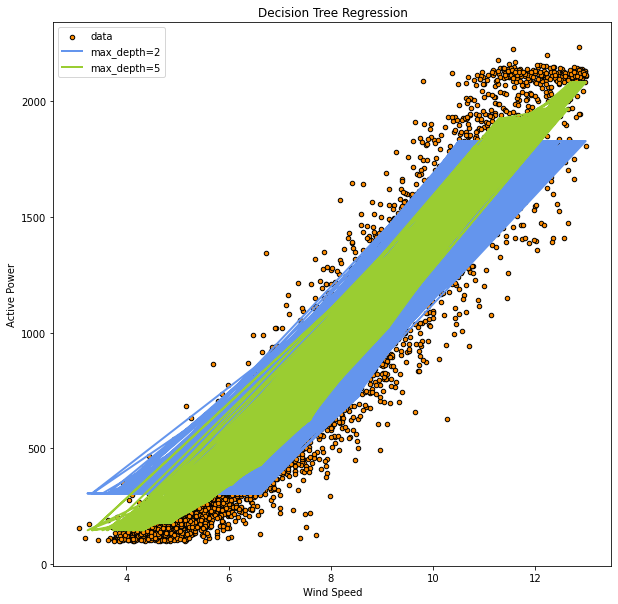

In [43]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.scatter(
    X_train[:, 1], y_train, s=20, edgecolor="black", c="darkorange", label="data"
)
plt.plot(X_test[:, 1], y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test[:, 1], y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("Wind Speed")
plt.ylabel("Active Power")
plt.title("Decision Tree Regression")
plt.legend()
plt.show(block=False)

In [44]:
# save the machine learning model to disk
import pickle

filename = "WT_ActivePower_model.sav"
pickle.dump(regr_2, open(filename, "wb"))

In [45]:
# Test the model with the scoring/testing data set
loaded_model = pickle.load(open(filename, "rb"))
result = loaded_model.score(X_test, y_test)
# print the model score
print(result)

0.9206642691565691


In [46]:
# Sample prediction
# define input
new_input = [[20, 9.6]]  # Temp= 20C, Wind Speed = 9.6 m/s
# get prediction for new input
new_output = regr_2.predict(new_input)
print(new_output)

[1289.13725133]


In [47]:
# Call the OpenWeather API to retrieve the forecasted air temperature and wind speed
# for Jamestown, Australia for the next 5 days
# City code information: http://bulk.openweathermap.org/sample/
#
url = "https://api.openweathermap.org/data/2.5/forecast?q=Jamestown,AU,2069194&units=metric&APPID=5dac981ce33f41f61d8d1ea06ee89798"
responseWeatherForecast = requests.get(url)

In [48]:
# Display first 3 results 
responseWeatherForecast.json()["list"][:3]

[{'dt': 1642377600,
  'main': {'temp': 18.71,
   'feels_like': 18.05,
   'temp_min': 18.71,
   'temp_max': 19.38,
   'pressure': 1012,
   'sea_level': 1012,
   'grnd_level': 961,
   'humidity': 54,
   'temp_kf': -0.67},
  'weather': [{'id': 804,
    'main': 'Clouds',
    'description': 'overcast clouds',
    'icon': '04d'}],
  'clouds': {'all': 100},
  'wind': {'speed': 3.67, 'deg': 183, 'gust': 4.16},
  'visibility': 10000,
  'pop': 0.08,
  'sys': {'pod': 'd'},
  'dt_txt': '2022-01-17 00:00:00'},
 {'dt': 1642388400,
  'main': {'temp': 20.34,
   'feels_like': 19.63,
   'temp_min': 20.34,
   'temp_max': 21.32,
   'pressure': 1012,
   'sea_level': 1012,
   'grnd_level': 961,
   'humidity': 46,
   'temp_kf': -0.98},
  'weather': [{'id': 804,
    'main': 'Clouds',
    'description': 'overcast clouds',
    'icon': '04d'}],
  'clouds': {'all': 100},
  'wind': {'speed': 3.08, 'deg': 175, 'gust': 3.87},
  'visibility': 10000,
  'pop': 0.02,
  'sys': {'pod': 'd'},
  'dt_txt': '2022-01-17 03:00:

In [49]:
# Store the forecasted air temperature, wind speed and timestamp from the API json response in a pandas DataFrame

import datetime

TempArray = []
WindSpeedArray = []
TimestampArray = []

for val in responseWeatherForecast.json()["list"]:
    tempC = val["main"]["temp"]
    windSpeedMeterPerSec = round(val["wind"]["speed"], 2)
    np.array(TempArray.append(tempC))
    np.array(WindSpeedArray.append(windSpeedMeterPerSec))
    np.array(
        TimestampArray.append(
            datetime.datetime.strptime(val["dt_txt"], "%Y-%m-%d %H:%M:%S")
        )
    )

dfWeatherForecast = pd.DataFrame(
    {
        "Timestamp": TimestampArray,
        "Temp (C)": TempArray,
        "Wind Speed (m/s)": WindSpeedArray,
    }
)

dfWeatherForecast

,Timestamp,Temp (C),Wind Speed (m/s)
0,2022-01-17 00:00:00,18.71,3.67
1,2022-01-17 03:00:00,20.34,3.08
2,2022-01-17 06:00:00,21.85,1.01
3,2022-01-17 09:00:00,21.36,0.17
4,2022-01-17 12:00:00,18.97,0.25
5,2022-01-17 15:00:00,17.89,1.82
6,2022-01-17 18:00:00,16.21,3.03
7,2022-01-17 21:00:00,14.54,5.06
8,2022-01-18 00:00:00,16.64,4.70
9,2022-01-18 03:00:00,21.20,3.89


In [50]:
# Use the machine learning model developed previously to predict the Active Power
# and add the values to the existing Data Frame

import pickle

filename = "WT_ActivePower_model.sav"
loaded_model = pickle.load(open(filename, "rb"))

PredictedPowerArray = []

for index, row in dfWeatherForecast.iterrows():
    new_input = [[row["Temp (C)"], row["Wind Speed (m/s)"]]]
    result = loaded_model.predict(new_input)
    np.array(PredictedPowerArray.append(result))

dfWeatherForecast["Predicted Active Power (kW)"] = pd.DataFrame(PredictedPowerArray)

dfWeatherForecast

,Timestamp,Temp (C),Wind Speed (m/s),Predicted Active Power (kW)
0,2022-01-17 00:00:00,18.71,3.67,146.932017
1,2022-01-17 03:00:00,20.34,3.08,146.932017
2,2022-01-17 06:00:00,21.85,1.01,146.932017
3,2022-01-17 09:00:00,21.36,0.17,146.932017
4,2022-01-17 12:00:00,18.97,0.25,146.932017
5,2022-01-17 15:00:00,17.89,1.82,146.932017
6,2022-01-17 18:00:00,16.21,3.03,146.932017
7,2022-01-17 21:00:00,14.54,5.06,226.020369
8,2022-01-18 00:00:00,16.64,4.70,180.248458
9,2022-01-18 03:00:00,21.20,3.89,146.932017


In [51]:
import plotly.express as px

px.scatter_3d(
    dfWeatherForecast,
    x="Temp (C)",
    y="Wind Speed (m/s)",
    z="Predicted Active Power (kW)",
    size="Predicted Active Power (kW)",
    color="Predicted Active Power (kW)",
    log_x=False,
    size_max=100,
    range_x=[0, 90],
    range_y=[0, 12],
    height=600,
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=27d58a9b-9aaa-47c5-b041-7e32d6d185a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>